# Решающие деревья

Цель этого ноутбука - знакомство с решающими деревьями, с их параметрами и свойствами. Рассмотрим примеры их использования для решения задач классификации и регрессии.

In [11]:
import numpy as np
import pandas as pd
import scipy.stats
import warnings
import graphviz
from tqdm import tqdm_notebook

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

sns.set(font_scale=1.5)
warnings.filterwarnings("ignore")

### 1. Задача классификации

Для начала рассмотрим задачу классификации на простом датасете, состоящем только из двух признаков, что позволит достаточно просто визуализировать данные. Для генерации такого простого датасета воспользуемся методом `make_classification` модуля `sklearn.datasets`:

#### Генерация данных

Основные аргументы функции:
* `n_samples` &mdash; размер выборки
* `n_features` &mdash; количество признаков всего (кроме целевого)
* `n_informative` &mdash; количество "информативных"признаков, от которых непосредственно зависит целевой признак
* `n_classes` &mdash; количество классов
* `n_redundant` &mdash; количество "лишних" признаков, не оказывающих воздействие на целевой

In [12]:
data, target = datasets.make_classification(
    n_samples=100, n_features=2, n_informative=2, n_classes=3, 
    n_redundant=0, n_clusters_per_class=1, random_state=3
)

Зададим цвета для отрисовки объектов и фона итоговой классификации:

In [13]:
colors = ListedColormap(['#FF3300', '#0099CC', '#00CC66'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightgreen'])

Отрисуем исходные данные:

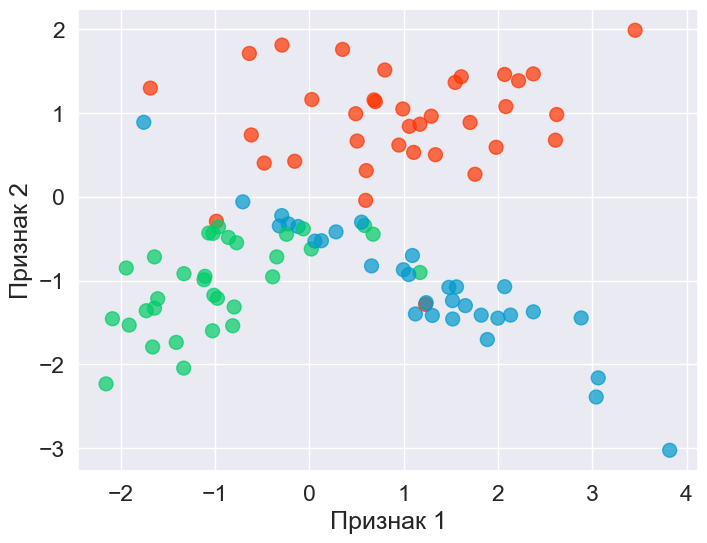

In [14]:
plt.figure(figsize=(8, 6))
grid_x1 = data[:, 0]
grid_x2 = data[:, 1]
plt.scatter(grid_x1, grid_x2, c=target, cmap=colors, s=100, alpha=0.7)
plt.xlabel('Признак 1'), plt.ylabel('Признак 2');

Разобьём данные на обучающую и тестовую выборки:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.3, random_state=777
)

Инициализируем и обучим решающее дерево для классификации с помощью `DecisionTreeClassifier`. Гиперпараметры дерева мы разберем далее.

In [16]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Посчитаем предсказания дерева и посчитаем точность полученной классификации. Точность классификации вычисляется как *доля правильно предсказанных классов*.

In [17]:
predictions = clf.predict(X_test)
accuracy_score(predictions, y_test)

0.9

#### Визуализация решающей поверхности (decision surface)

При использовании решающего дерева в простых задачах, где в данных один или два признака, бывает полезно посмотреть на разделяющую поверхность. По виду разделяющей поверхности можно получить представление, действительно ли дерево улавливает важные закономерности в данных и не возникло ли переобучения. Если данные имеют большое число признаков, то визуализировать разделяющую поверхность довольно сложно. Но в нашем случае (в данных ровно два признака) всё достаточно просто.

In [18]:
def get_meshgrid(data, step=.05, border=.5):
    '''
    Функция для получения сетки для входного набора данных
    
    Параметры:
    1) data - входной датасет
    2) step - шаг итоговой сетки
    3) border - величина отступа данных от границы области отрисовки
    '''
    
    x1_min, x1_max = data[:, 0].min() - border, data[:, 0].max() + border
    x2_min, x2_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x1_min, x1_max, step), 
                       np.arange(x2_min, x2_max, step))

In [19]:
def plot_decision_surface(
    estimator, X_train, y_train, X_test, y_test, colors=colors, 
    light_colors=light_colors, title='', metric=accuracy_score
):
    '''
    Отрисовка результатов классификации
    
    Параметры:
    1) estimator - классификатор
    2) X_train, y_train - тренировочные данны
    3) X_test, y_test - тестовые данные
    4) colors - цвета для отображения объектов
    5) light_colors - цвета отображения результата классификации
    6) title - заголовок
    7) metric - метрика качества классификации
    '''
    
    estimator.fit(X_train, y_train)
    
    plt.figure(figsize=(16, 6))
    
    # отображение разделяющей поверхности и точек обучающей выборки
    plt.subplot(1,2,1)
    x1_values, x2_values = get_meshgrid(X_train)
    x1_ravel, x2_ravel = x1_values.ravel(), x2_values.ravel()
    mesh_predictions_ravel = estimator.predict(np.c_[x1_ravel, x2_ravel])
    mesh_predictions = np.array(mesh_predictions_ravel).reshape(x1_values.shape)
    
    plt.grid(False)
    plt.pcolormesh(x1_values, x2_values, mesh_predictions, cmap=light_colors)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                s=100, cmap=colors, edgecolors='black')
    plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
    plt.title('Обучающая выборка, {}={:.2f}'.format(
        metric.__name__,metric(y_train, estimator.predict(X_train))
    ))
    
    # отображение разделяющей поверхности и точек тестовой выборки
    plt.subplot(1,2,2)
    plt.grid(False)
    plt.pcolormesh(x1_values, x2_values, mesh_predictions, cmap=light_colors)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                s=100, cmap=colors, edgecolors='black')
    plt.title('Тестовая выборка, {}={:.2f}'.format(
        metric.__name__, metric(y_test, estimator.predict(X_test))
    ))
    plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
    plt.suptitle(title, fontsize=20)

#### Влияние параметра `max_depth` на обучение

Посмотрим, как будет меняться разделяющая поверхность при изменении значения параметра `max_depth`.

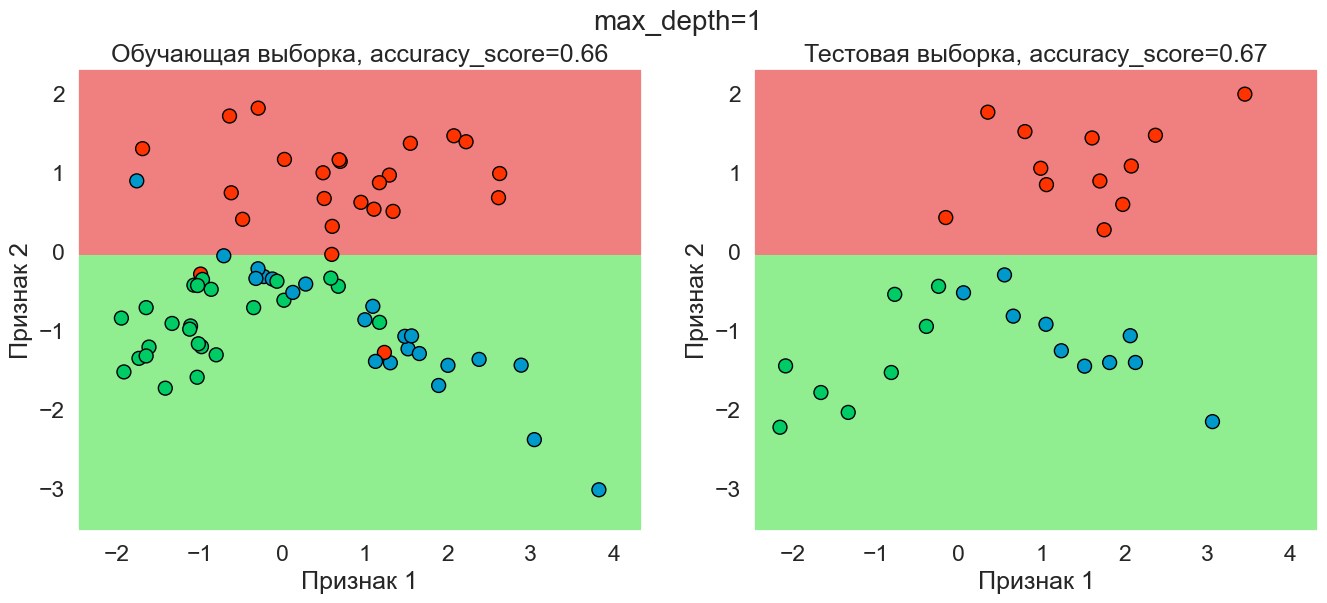

In [20]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=1)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_test, y_test, title='max_depth=1'
)

Разделяющая поверхность оказалась довольно простой. Ведь если глубина дерева равна одному, то в нём происходит разделение выборки ровно по одному признаку. 

Несложно заметить, что если в датасете для классификации $k$ классов, то необходимо брать дерево с глубиной не менее $\log_2 k$, так как мы хотим, чтобы в полученном дереве было не менее $k$ листьев. Иначе дерево будет предсказывать $< k$ классов, чего мы хотим избежать.


Попробуем увеличить максимальную глубину дерева.

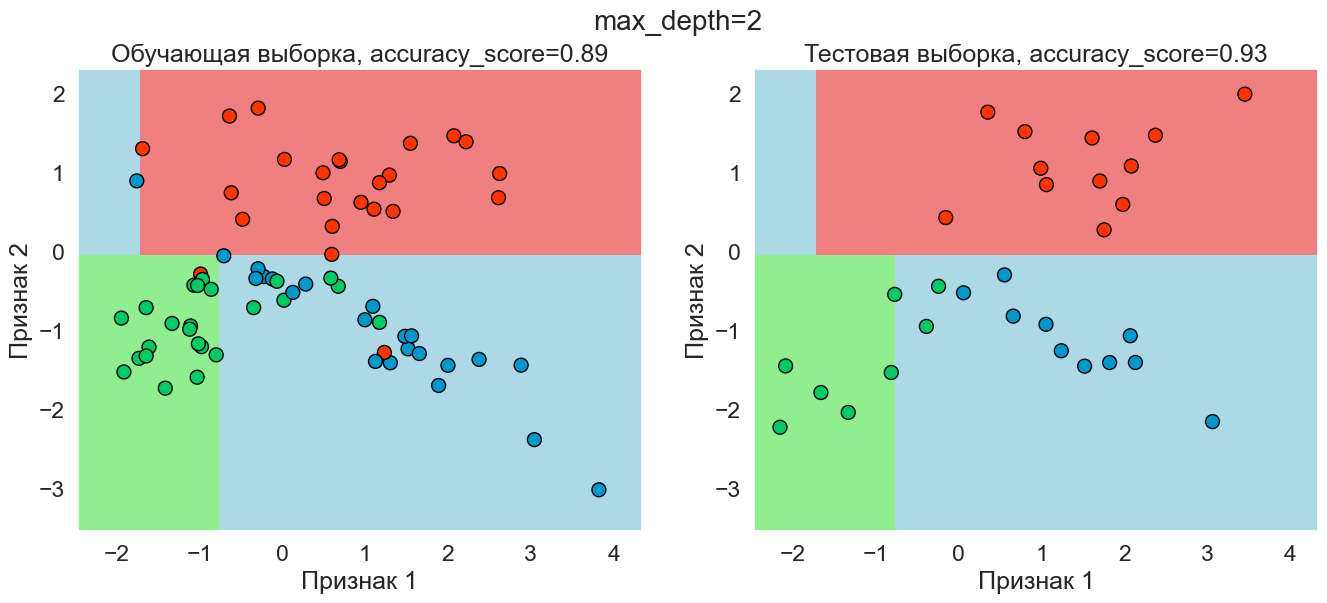

In [21]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=2)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_test, y_test, title='max_depth=2'
)

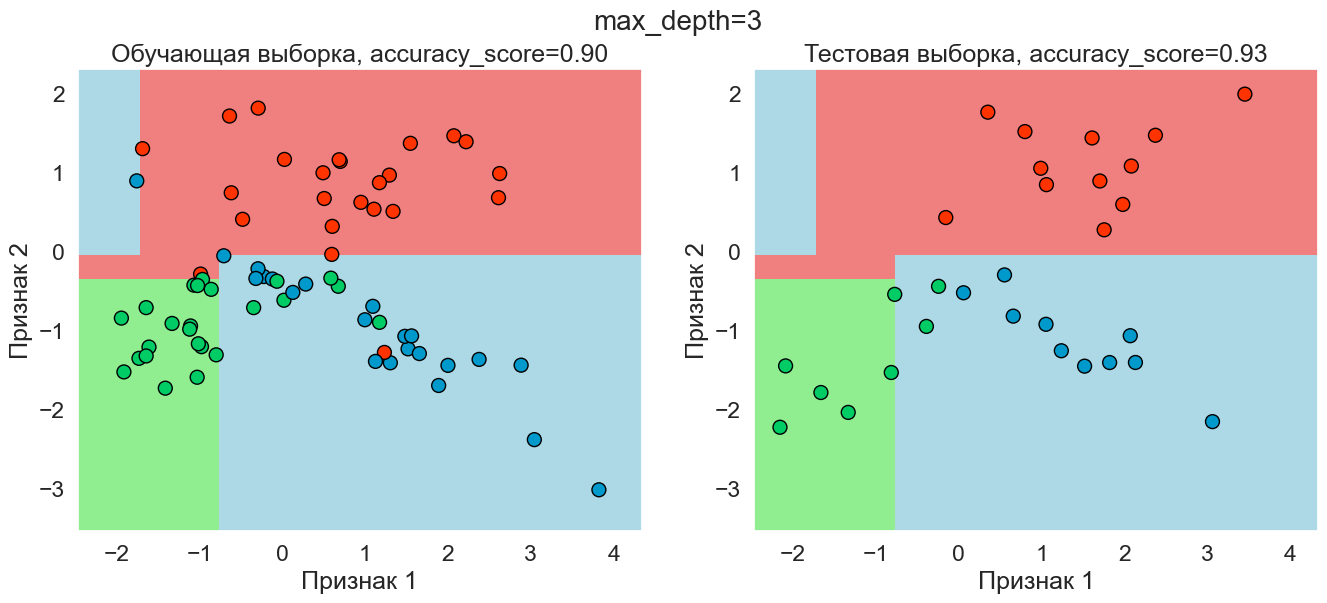

In [22]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=3)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_test, y_test, title='max_depth=3'
)

Заметим, что сложность разделяющей поверхности заметно увеличилась. Точность предсказания дерева заметно возросла. 

Для лучшего понимания работы алгоритма есть возможность визуализации дерева с помощью модуля `plot_tree`. В каждом узле приведены ключевые расчетные характеристики:

- Критерий деления узла. Принимает значение True или False. В зависимости от ответа определяется, в каком направлении вниз по дереву продвинется образец данных
- Значение критерия информативности Джини - должно уменьшаться по мере того, как мы движемся вниз по дереву
- Количество образцов прошедших в текущий узел
- Распределение элементов по классам. На примере верхнего узла: 0 класс – 24 элемента, 1 класс – 22 элемента, 2 класс 24 элемента 
- Принадлежность к классу для элементов из данного узла (класс с максимальным числом элементов)


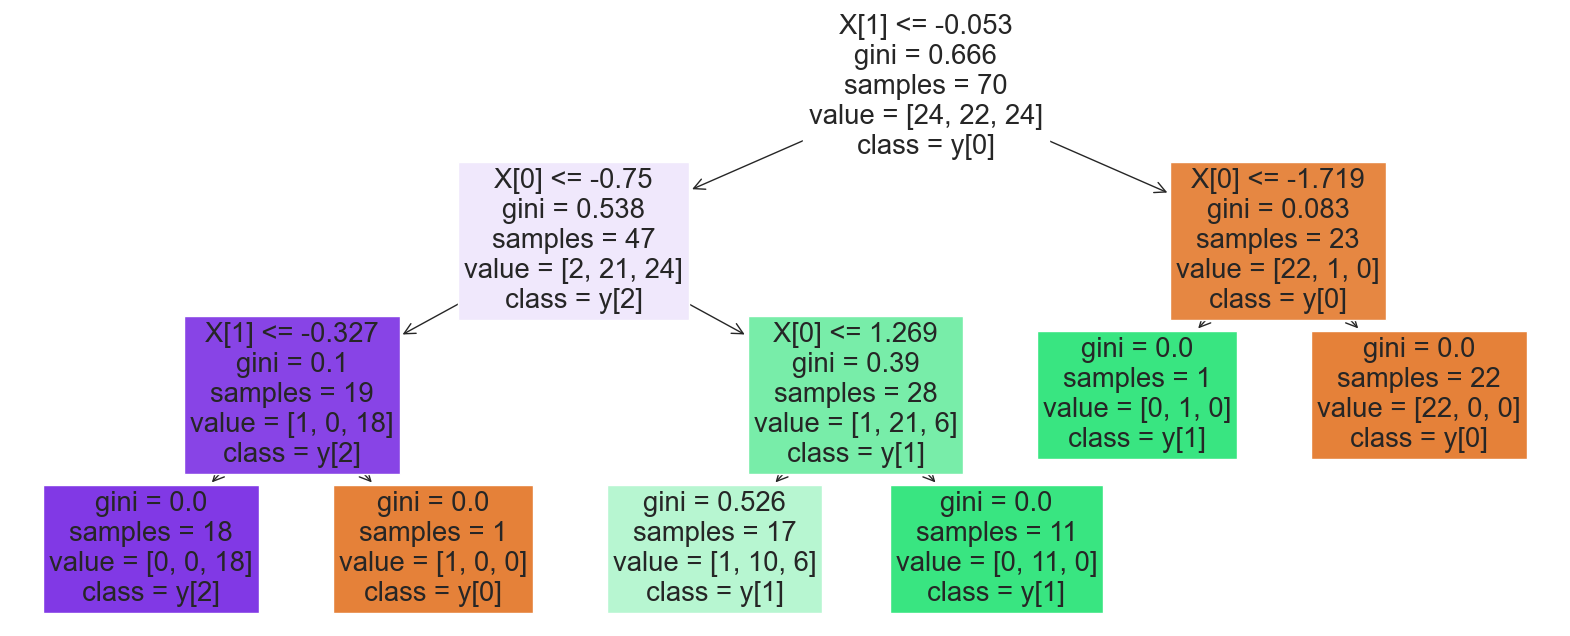

In [23]:
plt.figure(figsize=(20, 8))
tr = plot_tree(estimator, class_names=True, filled=True)

А теперь посмотрим, что произойдёт, если резко увеличить значение параметра `max_depth`.

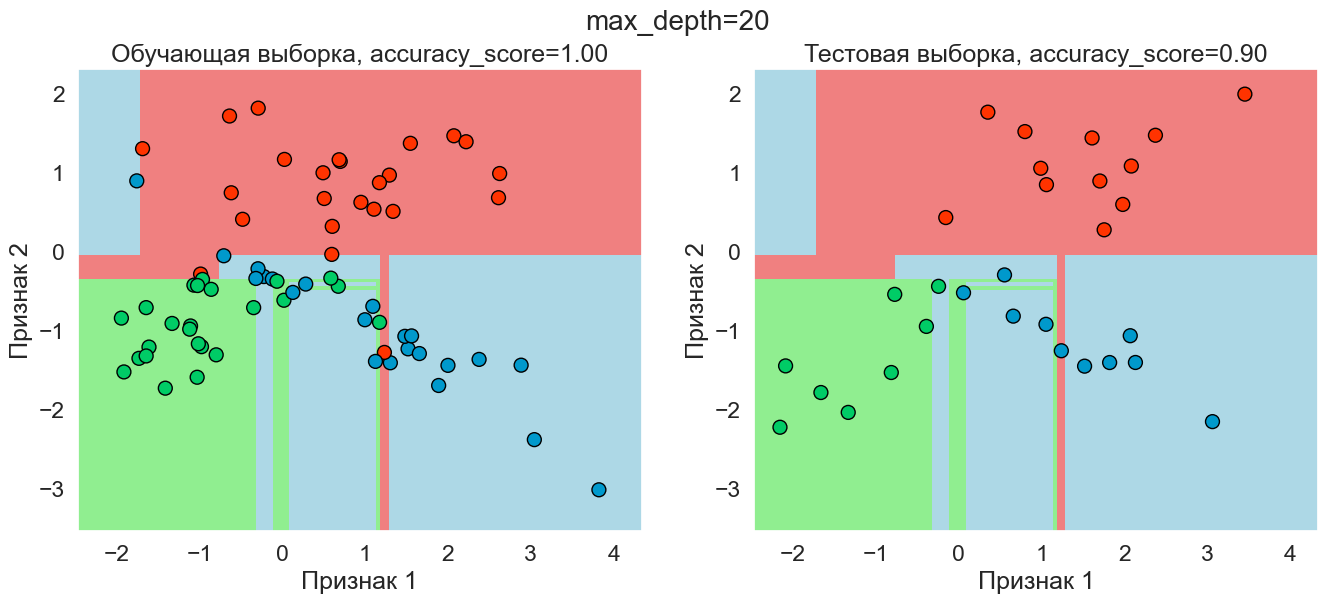

In [24]:
estimator = DecisionTreeClassifier(random_state=42, max_depth=20)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_test, y_test, title='max_depth=20'
)


Заметим, что accuracy на обучающей выборке стало равно единице, а на тестовой выборке стало хуже, чем при максимальной возможной глубине, равной трем. Это означает, что произошло переобучение дерева.

- увеличение значения параметра `max_depth` приводит к увеличению точности классификации на обучающей выборке, 
- но с некоторого момента увеличение значения `max_depth` приводит к ухудшению точности на тестовой выборке, так как начинается стадия переобучения.

#### Влияние параметра `min_samples_leaf` на обучение

Другим важным параметром решающего дерева является `min_samples_leaf` &mdash; ограничение наминимальное количество элементов, которое может находиться в листовой вершине дерева.

Данное условие необходимо для того, чтобы предсказание для данного листа было достаточно устойчиво. Например, если попал только один объект, то предсказание для данного листа будет равно таргету данного объекта, что является достаточно шумным предсказанием, а если попало 5 объектов, то предсказание будет более устойчиво к шуму и выбросам.

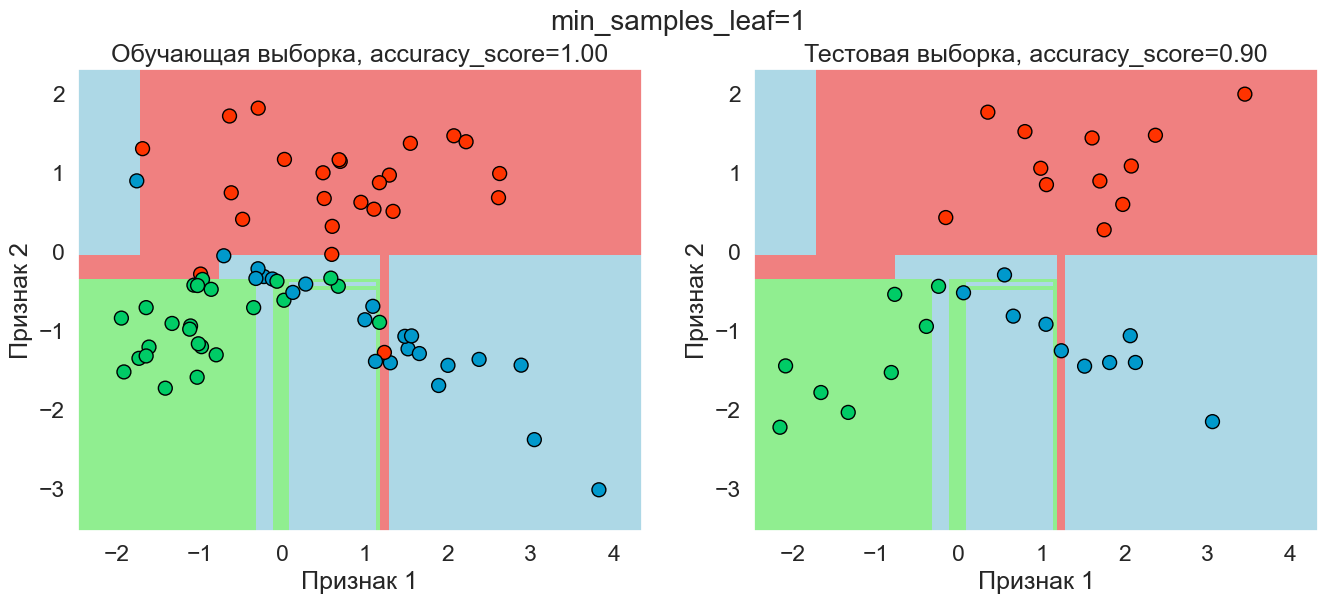

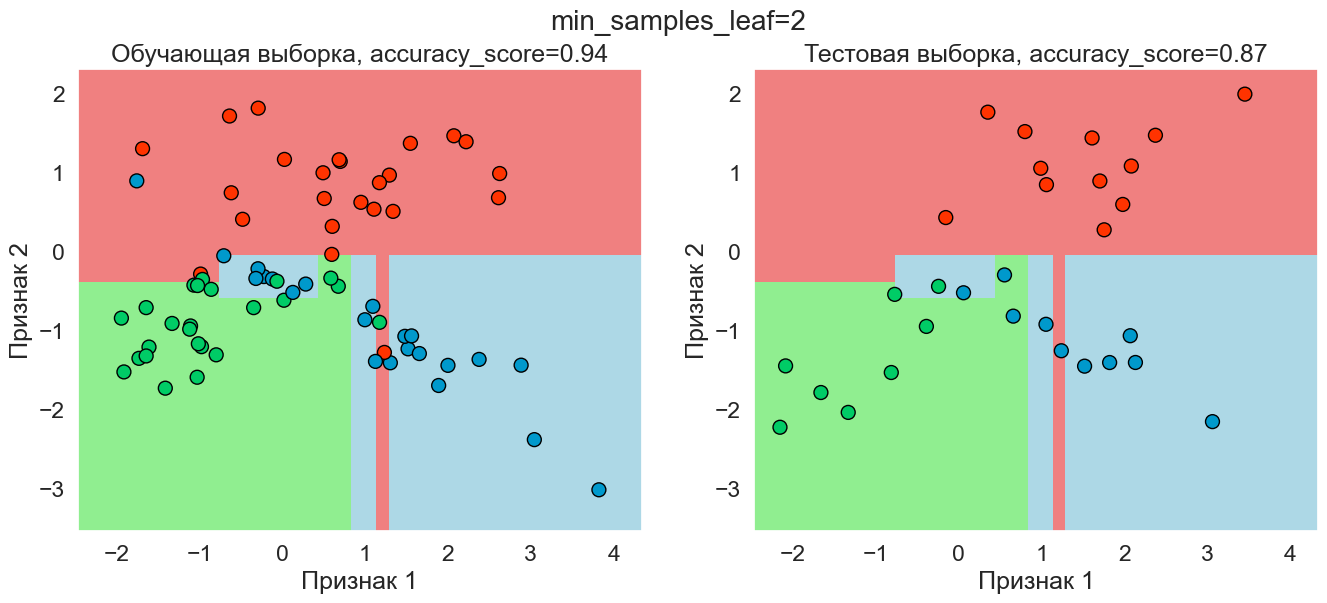

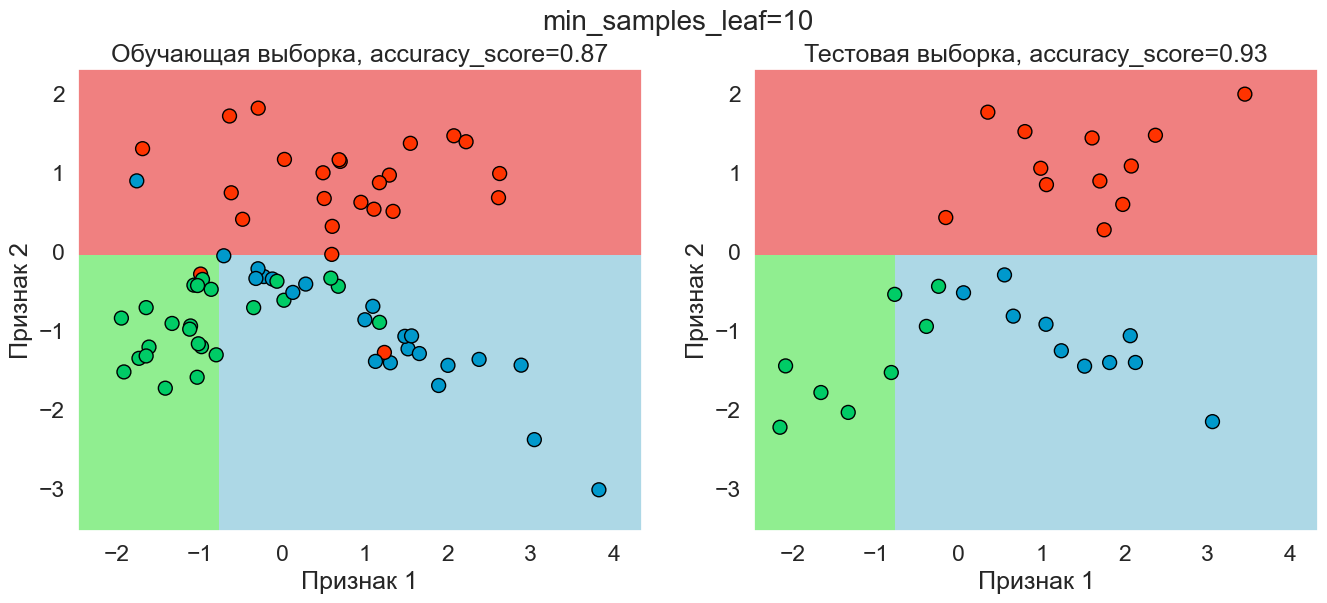

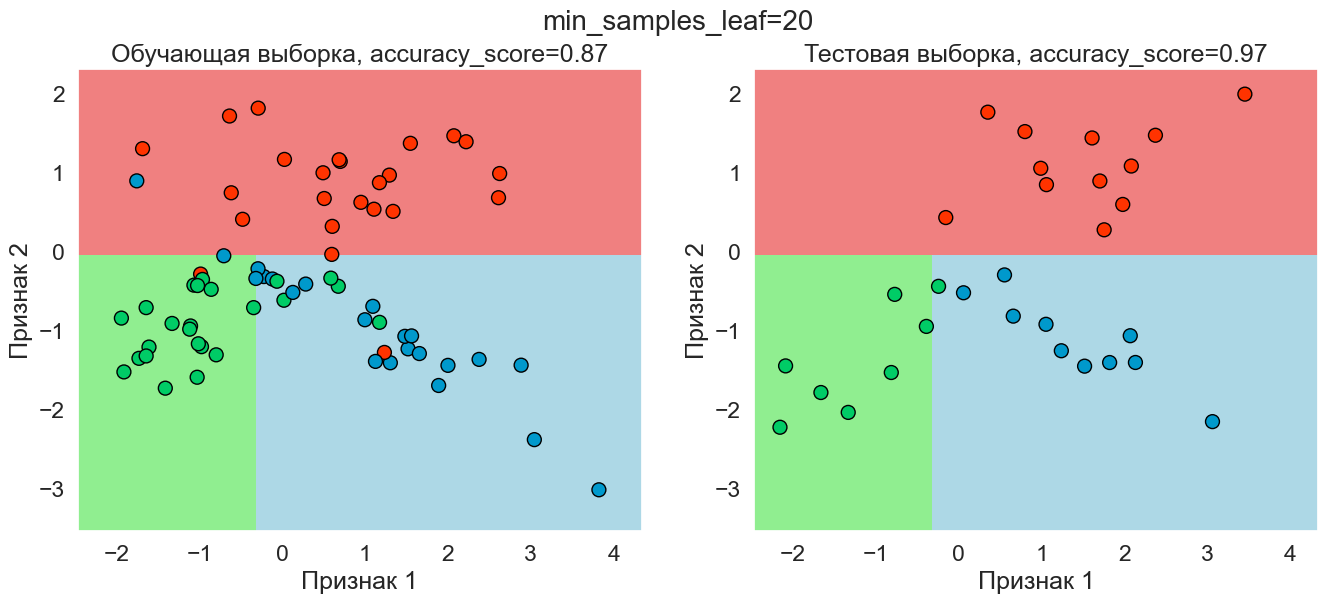

In [25]:
for min_samples_leaf in [1, 2, 10, 20]:
    estimator = DecisionTreeClassifier(
        random_state=42, min_samples_leaf=min_samples_leaf
    )
    plot_decision_surface(
        estimator, X_train, y_train, X_test, y_test, 
        title=f'min_samples_leaf={min_samples_leaf}'
    )

Построим график зависимости accuracy от `min_samples_leaf` на обучающей и на тестовой выборках.

In [26]:
def get_train_and_test_accuracy(param_name, grid):
    '''
    Функция для оценки точности классификации 
    для заданных значений параметра param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра
    '''
        
    train_acc, test_acc = [], []
    
    for param_value in grid:
        estimator = DecisionTreeClassifier(**{param_name: param_value})
        estimator.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, estimator.predict(X_train)))
        test_acc.append(accuracy_score(y_test, estimator.predict(X_test)))
    return train_acc, test_acc

In [27]:
def plot_dependence(param_name, grid=range(2, 20), title=''):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) title - заголовок графика
    '''
    
    plt.figure(figsize=(12, 6))
    
    train_acc, test_acc = get_train_and_test_accuracy(param_name, grid)
        
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='test', lw=3)
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('Точность классификации')
    plt.title(title, fontsize=20)
    plt.show()

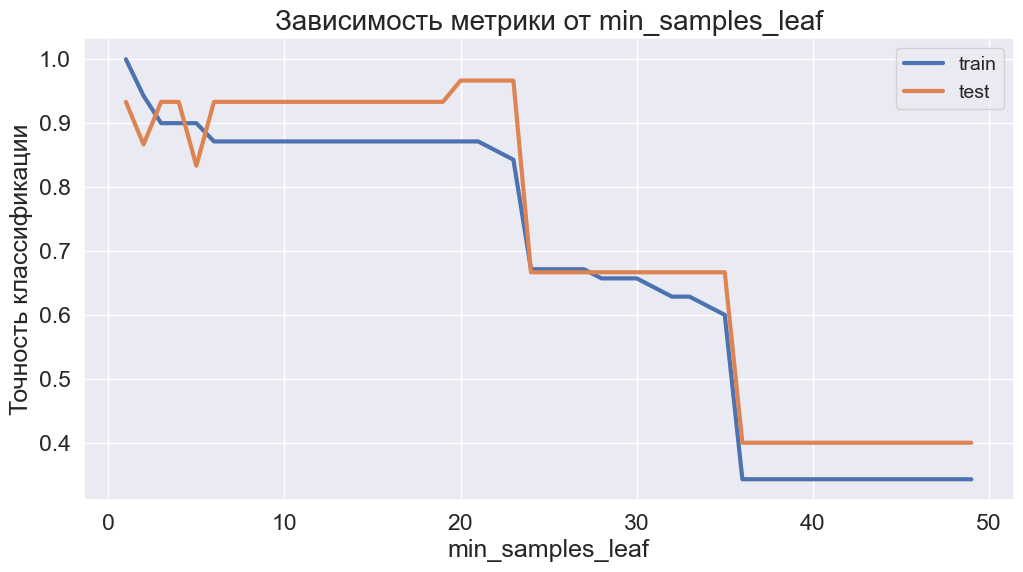

In [28]:
plot_dependence(
    'min_samples_leaf', range(1, 50), 
    title='Зависимость метрики от min_samples_leaf'
)

Увеличение значения параметра `min_samples_leaf` &mdash; один из способов борьбы с переобучением при использовании решающих деревьев.

Но, всё же, стоит заметить, что повышение значения `min_samples_leaf` делает разделяющую поверхность проще. Значит, при слишком больших значениях `min_samples_leaf` модель становится слишком простой и перестаёт улавливать закономерности из данных.

Например, зададим `min_samples_leaf` заведомо большим:

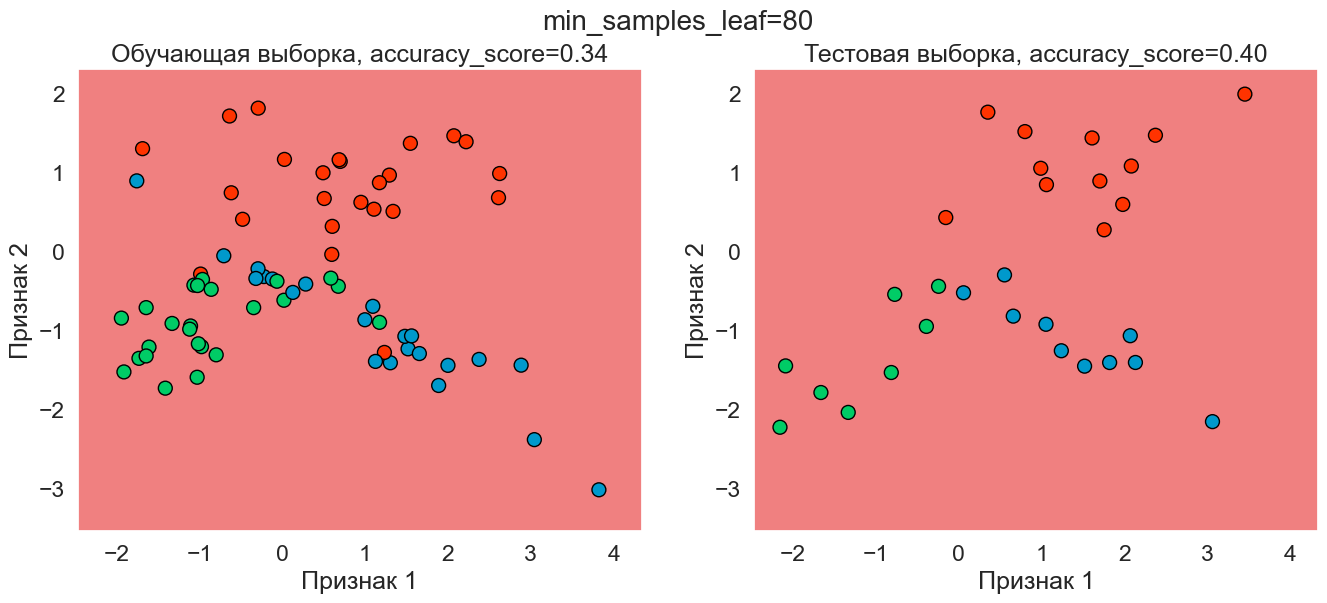

In [29]:
estimator = DecisionTreeClassifier(
    random_state=42, min_samples_leaf=90
)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_test, y_test, title='min_samples_leaf=80'
)

#### Влияние параметра `min_samples_split` на обучение

Теперь исследуем влияние параметра &mdash; `min_samples_split`, минимальное количество элементов, которое должно попасть в вершину, чтобы её можно было разделить. 

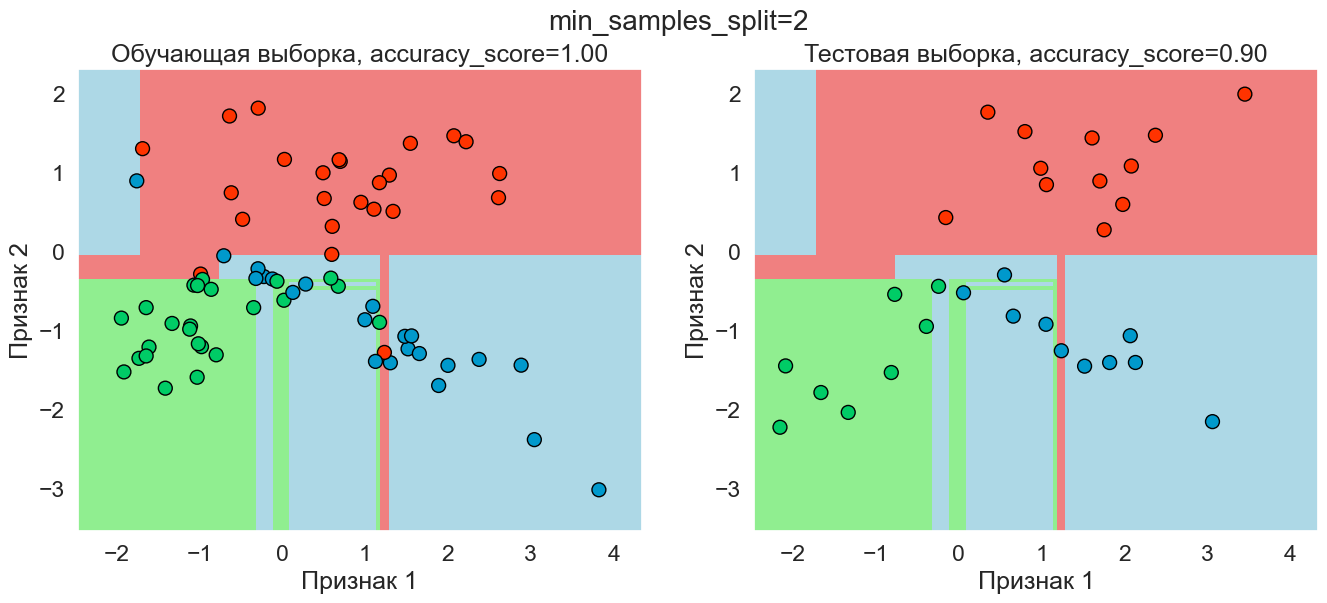

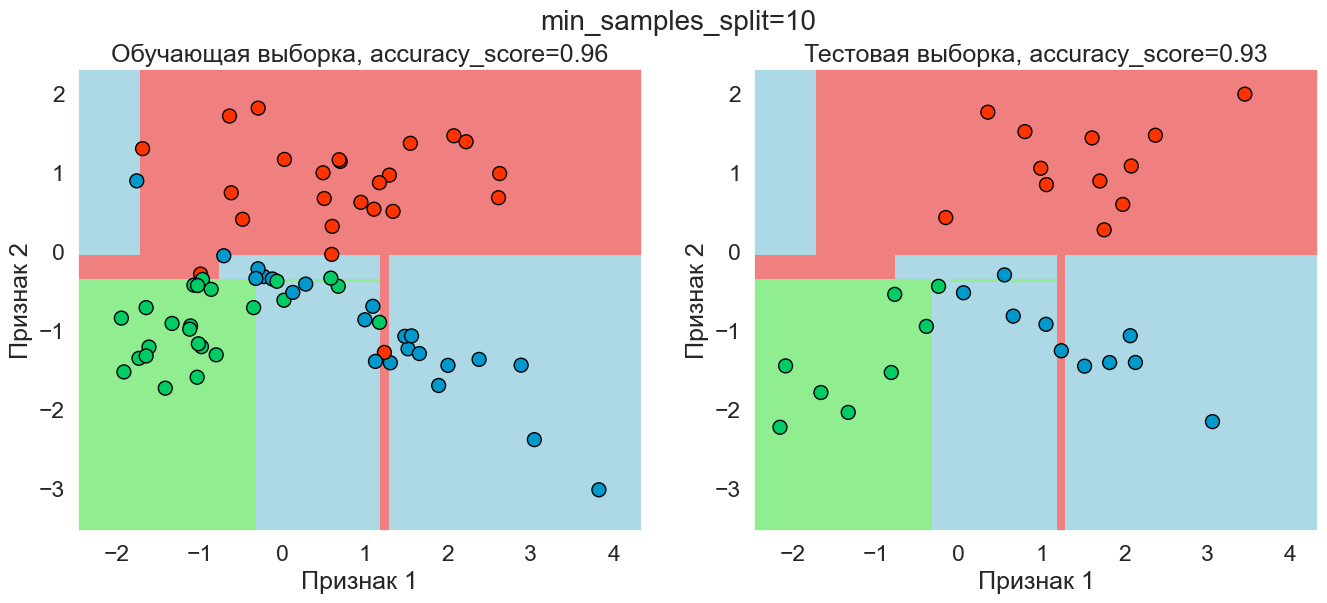

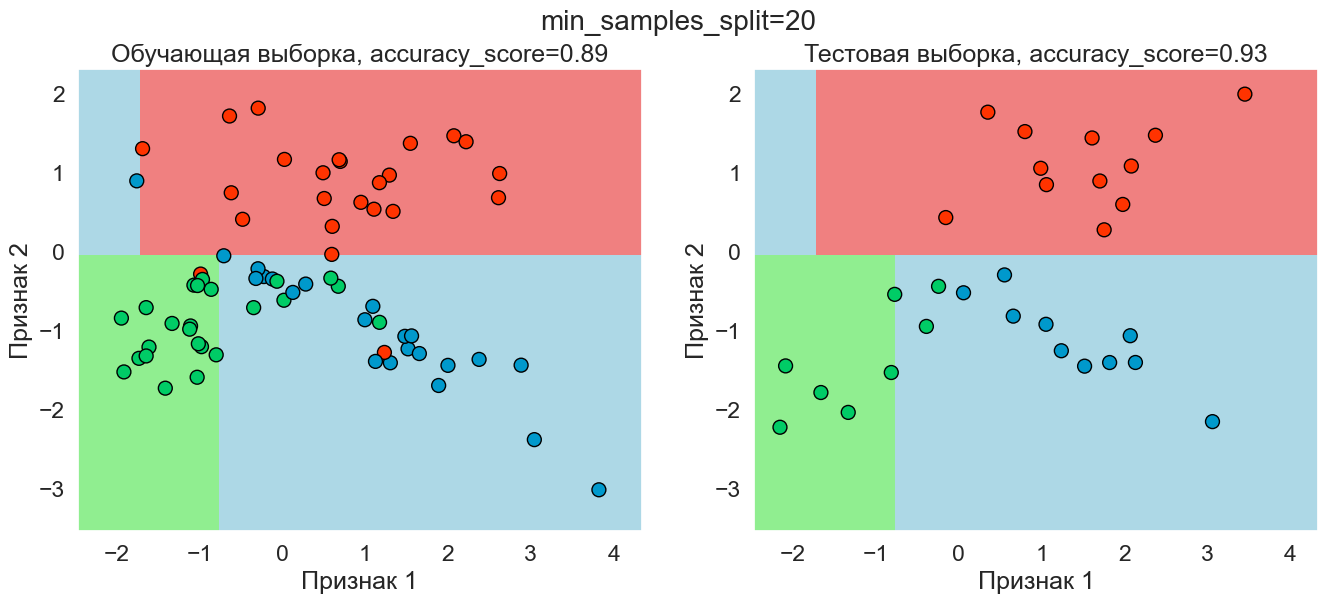

In [30]:
for min_samples_split in [2, 10, 20]:
    estimator = DecisionTreeClassifier(
        random_state=42, min_samples_leaf=1,
        min_samples_split=min_samples_split
    )
    plot_decision_surface(
        estimator, X_train, y_train, X_test, y_test, 
        title=f'min_samples_split={min_samples_split}'
    )

А теперь попробуем резко увеличить значение `min_samples_split`.

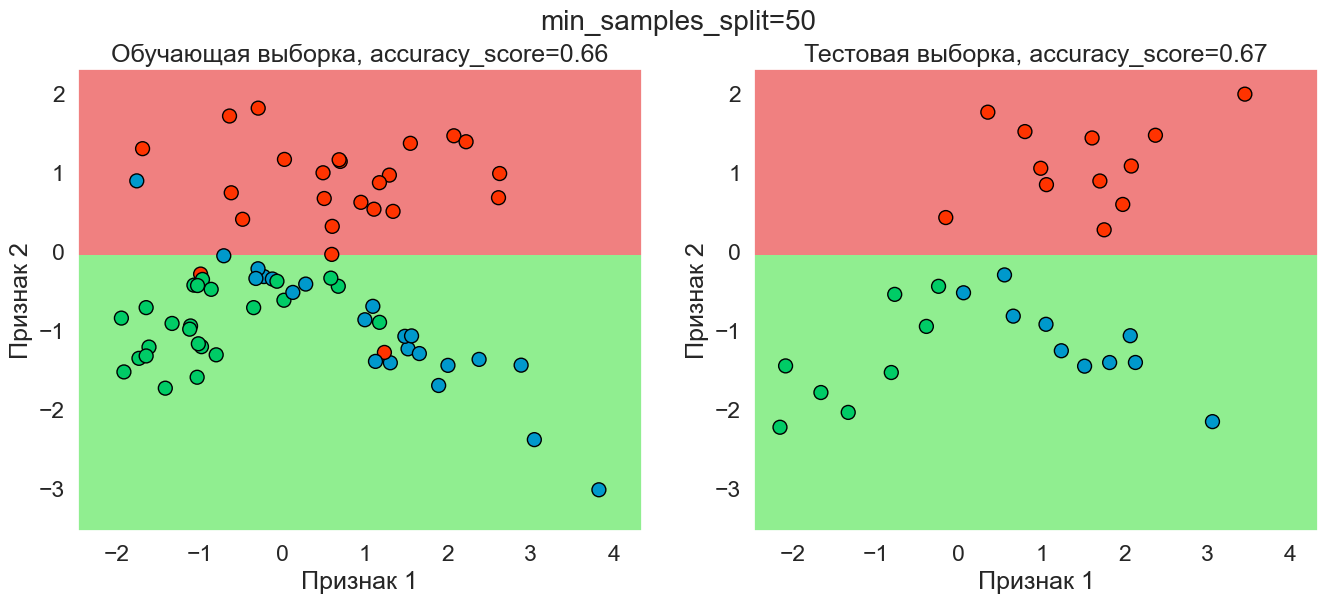

In [31]:
estimator = DecisionTreeClassifier(
    random_state=42, min_samples_leaf=1, min_samples_split=50
)
plot_decision_surface(
    estimator, X_train, y_train, 
    X_test, y_test, title='min_samples_split=50'
)

Таким образом, при изменении значения `min_samples_split` происходит ситуация, аналогичной случаю, когда мы варьируем `min_samples_leaf`. И здесь наблюдается следующая закономерность: с увеличением значения `min_samples_split` качество 
* на обучающей выборке падает, 
* на тестовой выборке &mdash; до некоторого момента возрастает. 

Кроме того, с увеличением `min_samples_split` разделяющая поверхность становится проще.

#### Другие параметры:

Обратим внимание еще на несколько важных настроечных параметров модуля `DecisionTreeClassifier` в `sklearn`:

1. `criterion` &mdash; критерий, по которому происходит разбиение вершины дерева. Стандартные критерии для классификации &mdash; критерий Джини (`giny`) и энтропийный критерий (`entropy`), при этом `giny` &mdash; критерий по умолчанию


2. `splitter` &mdash; способ разбиения вершины решающего дерева. Есть два возможных варианта: `best` и `random`. В первом случае рассматриваются все возможные способы разбить вершину дерева на две и берётся тот из них, значение критерия для которого оптимально. При `splitter=random` берётся несколько случайных возможных разбиений и среди них выбирается то, значение критерия для которого оптимально


3. `max_features` &mdash; максимальное количество признаков, которые могут быть перебраны при разбиении вершины дерева. Перед каждым разбиением вершины генерируется выборка из `min(d, max_features)` случайных признаков (`d` &mdash; количество признаков в датасете) и только эти признаки рассматриваются как разделяющие


4. `min_impurity_decrease` &mdash; минимальное значение уменьшения взвешенного критерия неопределенности (`impurity`), чтобы можно было разбить выборку в данной вершине

### 2. Регрессия с использованием решающего дерева

В регрессии будем использовать все те же параметры разбиения. Но в качестве критерия неопределенности (параметр `criterion`) используются `squared_error` (по умолчанию), `friedman_mse`, `absolute_error`


Сгенерируем данные

In [32]:
data, target = datasets.make_regression(
    n_features=2, n_informative=2, random_state=3, n_samples=200
)

Отрисуем полученный датасет:

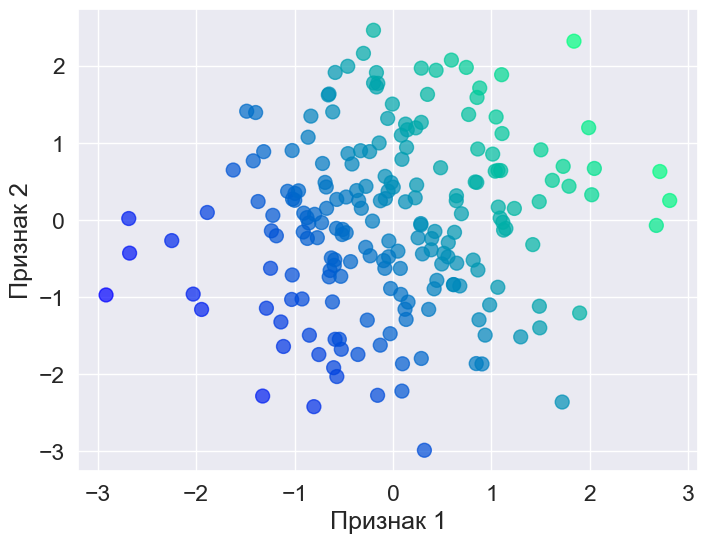

In [33]:
plt.figure(figsize=(8, 6))
grid_x1 = data[:, 0]
grid_x2 = data[:, 1]
plt.scatter(grid_x1, grid_x2, c=target, s=100, alpha=0.7, cmap='winter')
plt.xlabel('Признак 1'), plt.ylabel('Признак 2');

Разобьём данные на ообучающую и тестовую подвыборки:

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=42
)

Исследуем зависимость качества работы регрессионного дерева в зависимости от максимально возможной его глубины.  

Цвет фона будет соответсвовать ответу в текущем листе (в отличие от задачи классификации это не класс, а некоторое число)

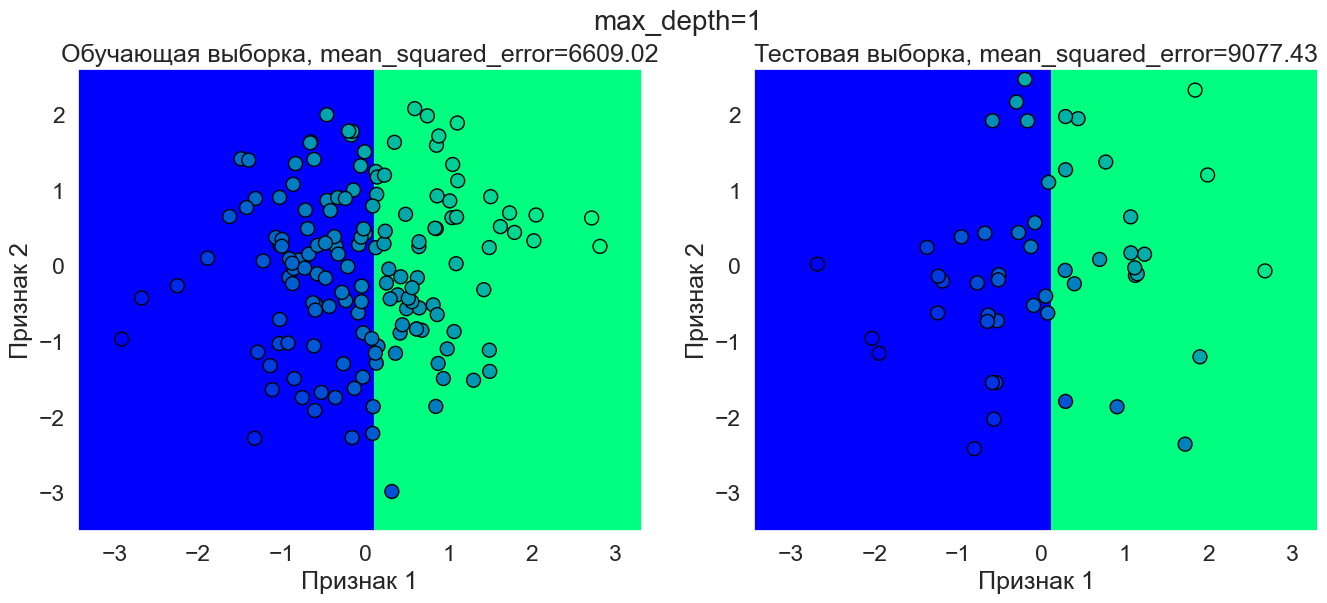

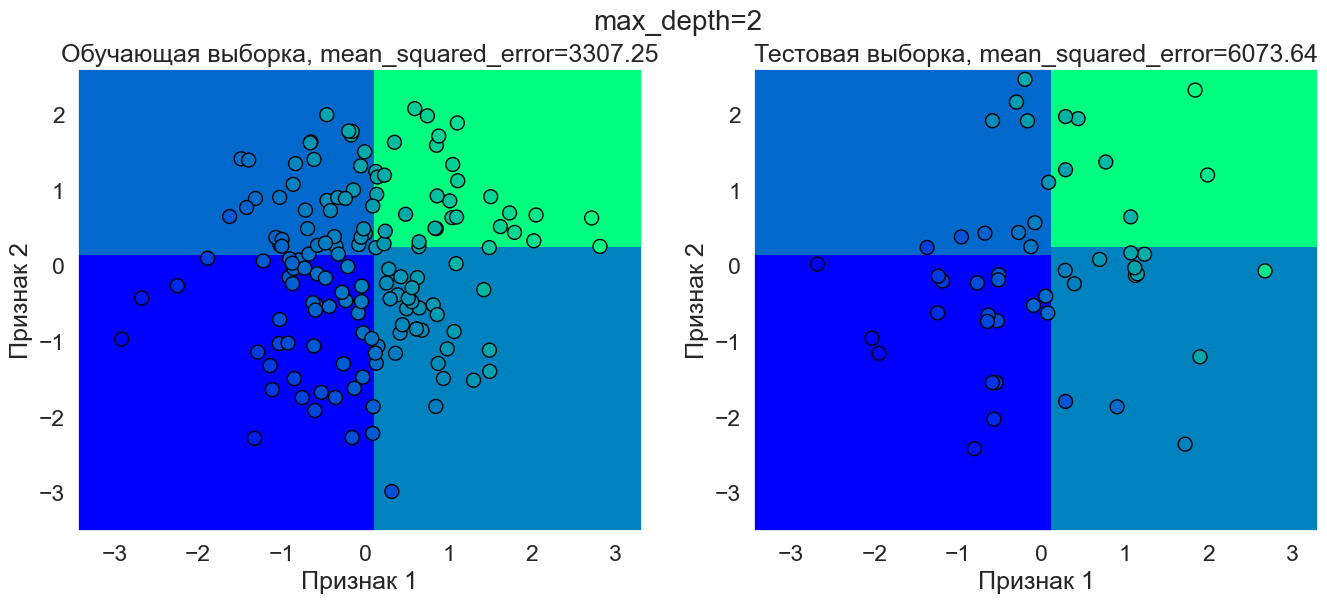

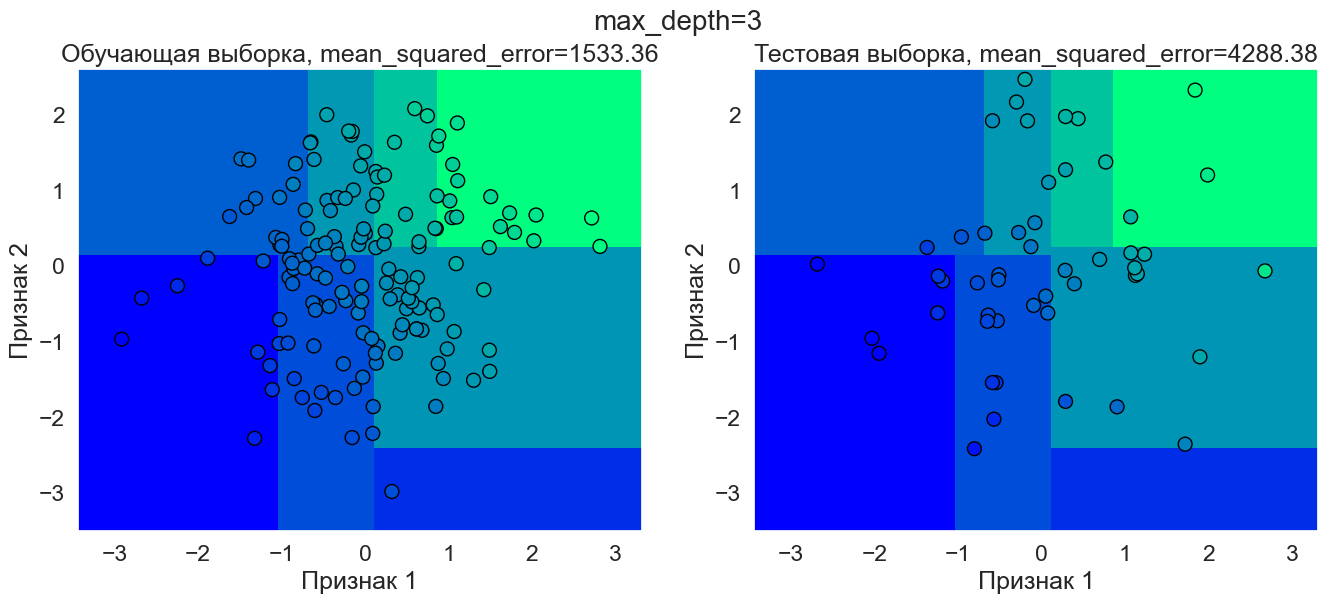

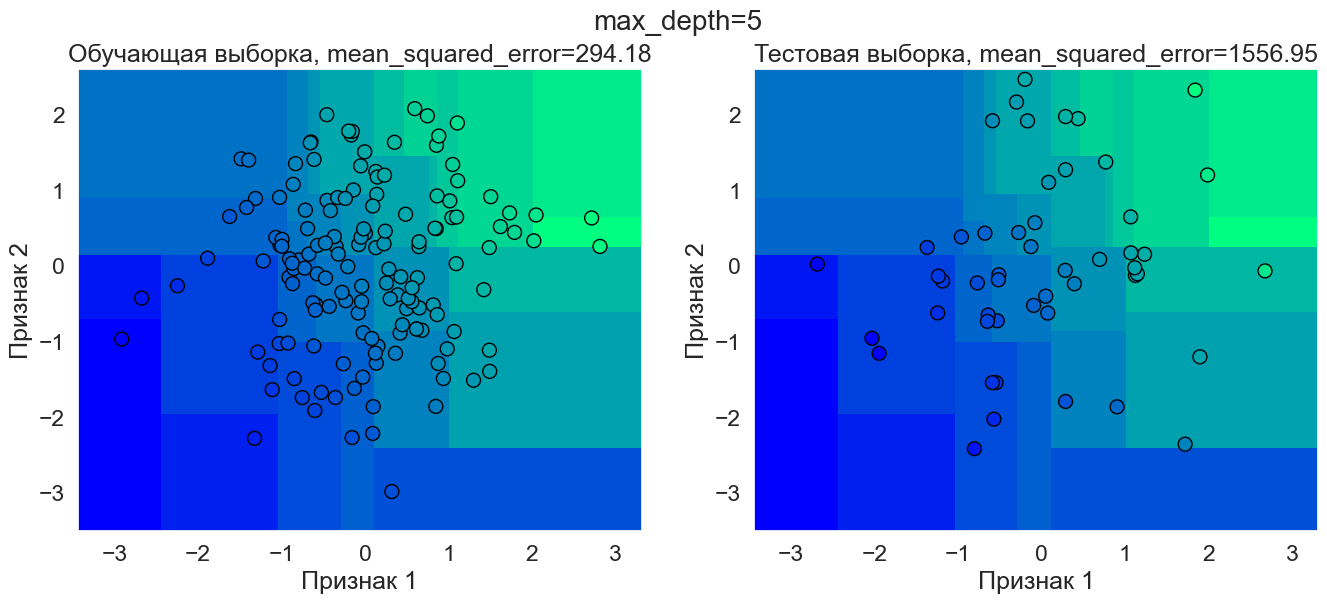

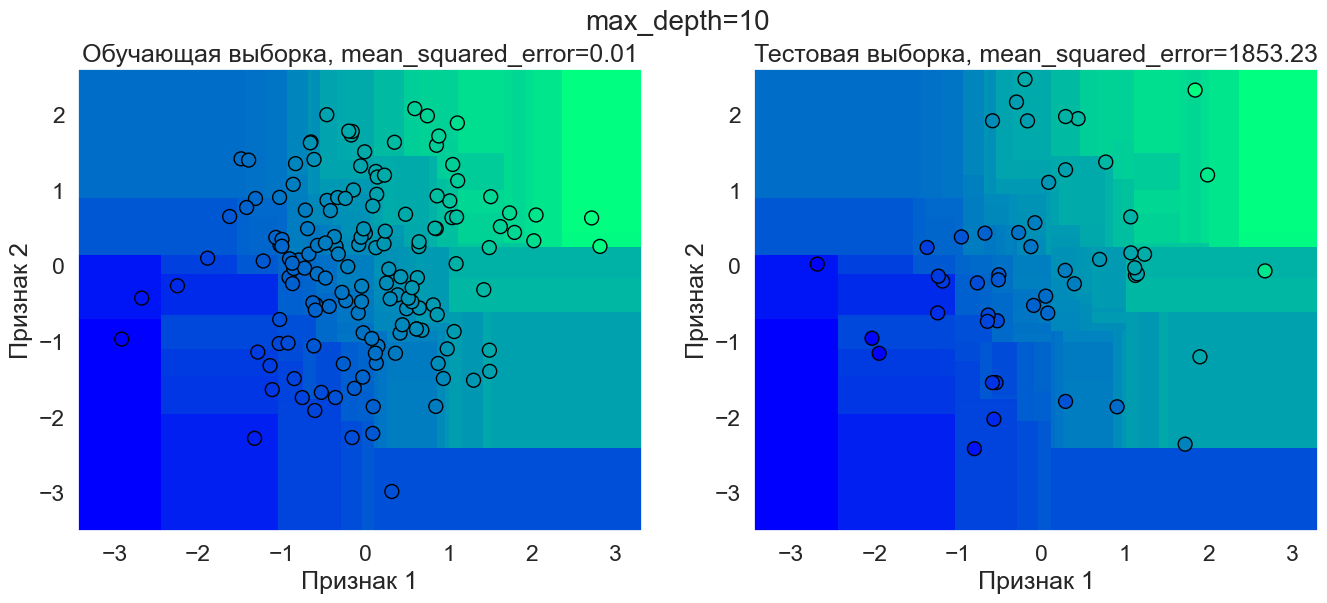

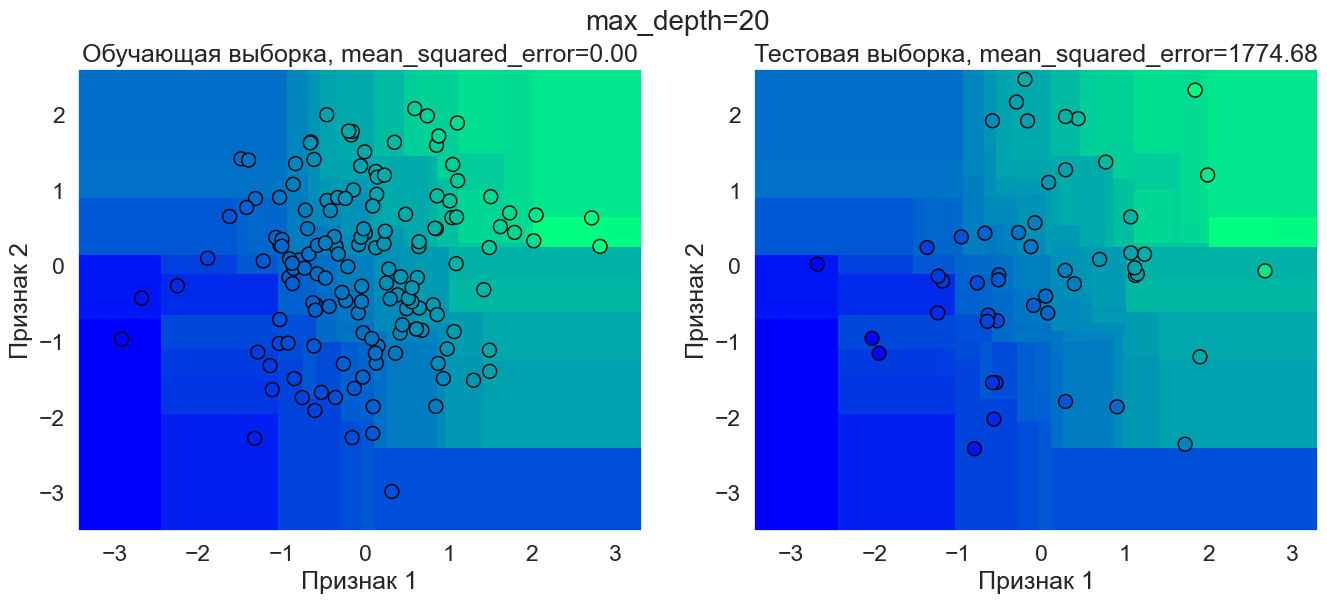

In [35]:
for max_depth in [1, 2, 3, 5, 10, 20]:
    estimator = DecisionTreeRegressor(random_state=42, max_depth=max_depth)
    plot_decision_surface(
        estimator, X_train, y_train, X_test, y_test, 
        title='max_depth={}'.format(max_depth), colors='winter',
        light_colors='winter', metric=mean_squared_error
    )

Для решения задачи регрессии недостаточно малой глубины дерева, но как в задаче классификации при слишком большой глубине может происходить переобучение. Регрессионная зависимость, восстанавливаемая деревом, выглядит сильно сложно.

### Titanic Dataset:

Рассмотрим другую более практическую задачу бинарной классификации с использованием решающих деревьев. В качестве тестового набора данных мы будем использовать стандартный датасет Титаник. Попытаемся на основе информации о пассажирах Титаника предсказать удастся ли им выжить в ходе крушения. Данная модель не претендует на роль самой точной для текущей задачи, однако в ходе ииследования мы коснемся ряда важных аспектов:

- Исследование и обработка исходных данных
- Обучение модели на основе решающих деревьев
- Поиск оптимальных параемтров модели
- Визуализация окончательной модели

Данные для обучения и валидации были взяты с сайта Kaggle: `https://www.kaggle.com/competitions/titanic/data`

Импортируем необходимые библиотеки:

In [36]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from catboost.datasets import titanic


from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

Для начала загрузим данные:

In [37]:
# train = pd.read_csv('Input/train.csv')
# test = pd.read_csv('Input/test.csv')
train, test = titanic()

original_train = train.copy()
PassengerId = test['PassengerId']

Посмотрим на несколько первых элементов исходной выборки тренировочных данных:

In [38]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [40]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Как можно заметить, наш набор данных нуждается в некоторой предобработке. 

Для таких параметров как 'Age', 'Cabin', 'Embarked' присутствуют пропуски в данных.

Целевой класс 'Survived' уже находится в двоичном формате, поэтому дополнительное форматирование не требуется, но такие параметры, как 'Name', 'Ticket' или 'Cabin', необходимо адаптировать для задачи, которую мы пытаемся решить, так же мы в праве добавить новые признаки путем слияния или перегруппировки уже существующих.

Объединим тренировочный и тестовый датасет для совместной обработки:

In [41]:
full_data = [train, test]

Обработаем параметр указывающий на наличие каюты у пассажира

In [42]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

Создание нового параметра 'FamilySize' используя комбинацию параемтров 'SibSp' (Количество братьев и сестер)'Parch' (Количетсво родителей и детей) 

In [43]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

Создание нового параметра 'IsAlone' на основе параметра 'FamilySize'

In [44]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

Заполнение пропусков для признака 'Порт посадки'

In [45]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

Заполнение пропусков для признака 'Пассажирский тариф' медианным значением

In [46]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

Заполнение пропусков для признака 'Возраст'

In [47]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

Определим функцию для извлечения из столбца 'Name' титула (Mr/Miss/Master/Don/...)

In [48]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

Добавим новый параметр 'Title'

In [49]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

Скомпонуем редкие названия для параметра 'Title' в одну общую группу "Rare"

In [50]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Обработка стобца 'Sex', замена 'female': 0, 'male': 1

In [51]:
for dataset in full_data:
    # Обработка стобца 'Sex', замена 'female': 0, 'male': 1
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

Мапинг признака 'Title'

In [52]:
for dataset in full_data:
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

Мапинг признака 'Порт посадки'

In [53]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

Мапинг признака 'Пассажирский тариф'

In [54]:
for dataset in full_data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

Мапинг признака возраст

In [55]:
for dataset in full_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

Удаление неинформативных признаков

In [56]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [57]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


Теперь наш набор данных намного чище, чем раньше, содержит только численные значения и потенциально значенимые признаки. Давайте теперь изучим взаимосвязь между нашими переменными, построив корреляцию Пирсона между всеми атрибутами

Добавить комментарий о том, что данные приведены к числовому формату

<AxesSubplot: title={'center': 'Pearson Correlation of Features'}>

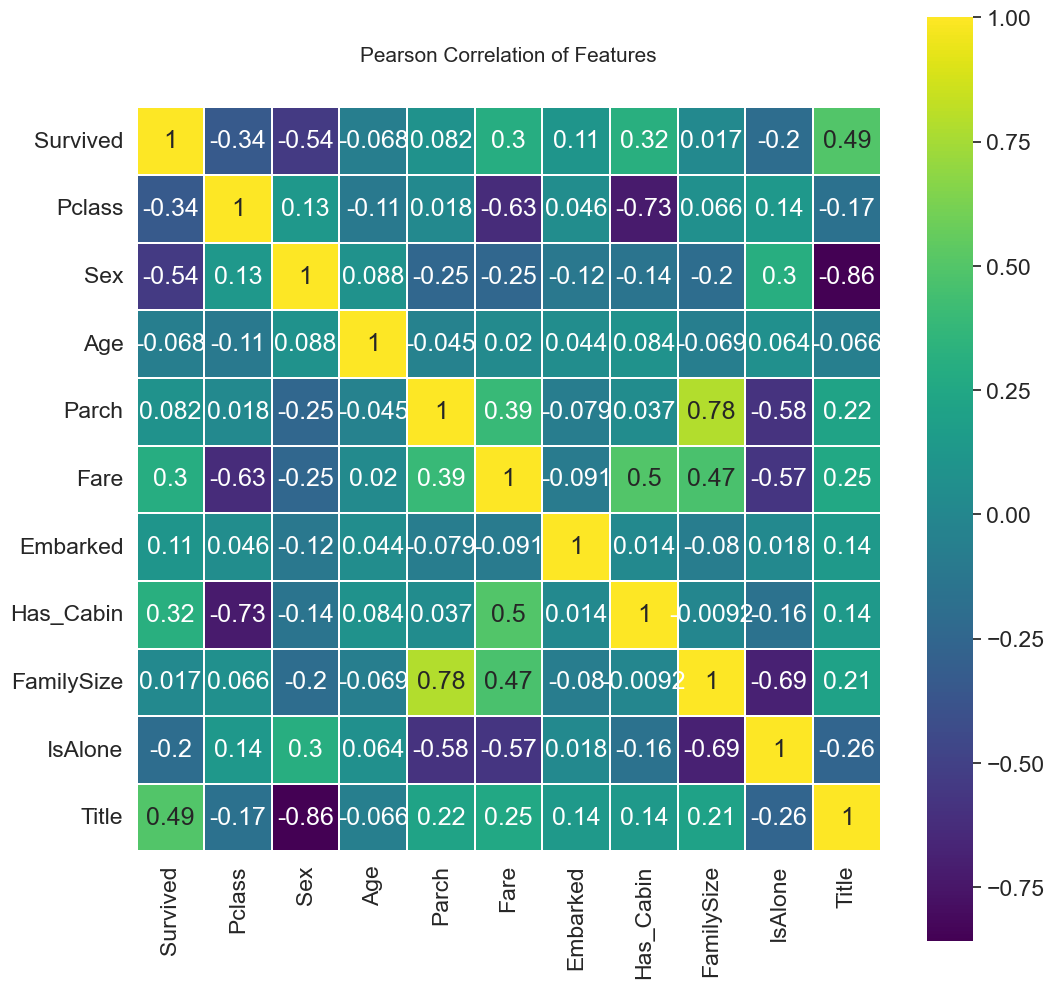

In [58]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Исходя из полученной таблицы можно заметить, что параметры Пол и Титул показывают самые высокие корреляции (в абсолютном выражении) с классом (Выживший): 0,54 и 0,49 соответственно. Но абсолютная корреляция между ними также очень высока (0,86, самый высокий показатель в нашем наборе данных), поэтому они, вероятно, несут одинаковую информацию, и использовать их в качестве входных данных для одной и той же модели было бы не очень хорошей идеей. Высока вероятность того, что один из них будет использоваться для первого узла в нашем окончательном дереве решений, поэтому давайте сначала изучим эти параметры и сравним их.

Давайте посмотрим как значения параметров 'Title' и 'Sex' соотносятся со значениями целевой переменной 'Survived' вычислив базовые статистики, такие как 'mean', 'count', 'sum':

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

In [59]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

sex_mapping = {{'female': 0, 'male': 1}} 

In [60]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

Для наших целей параметр титул кажется более полезным, чем пол. Это может быть связано с тем, что в большинстве случаев параемтр титул неявно включает информацию о поле. Чтобы убедиться в этом, мы можем использовать сделанную нами копию исходных обучающих данных и проверить распределение пола, сгруппированное по титулу:

In [61]:
title_and_sex = original_train.copy()[['Name', 'Sex']]

title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

Можем заметить, что, за исключением одного наблюдения (женщина со званием «доктор»), все наблюдения для каждого титула имеют один и тот же пол. Таким образом, параметр Title содержит всю информацию, представленную параметром Sex. Кроме того, титул может быть более ценным для нашей задачи, поскольку он содержит в себе другие характеристики пассажиров, такие как возраст, социальный статус, ...

Прежде чем приступить к обучению модели, давайте кратко объясним, как они работают. Основная задачи при построении дерева - поиск наилучшего разделения для каждого узла дерева. Выбор лучшего разделения — вопрос субъективный, поэтому на практике для его оценки используются разные показатели. Одним из наиболее популярных показателей является критерий информативности Джини.

В процессе построения дерева алгоритм пытается минимизировать `Критерий ошибки` который вычисляется по следующей формуле:

$Q(x_{m},j,t) = \frac{|x_{l}|}{|x_{m}|}\cdot S(X_{l}) + \frac{|x_{r}|}{|x_{m}|}\cdot S(X_{r})$

Функция S(x) называется критерием информативности, её значение уменьшается с уменьшением разброса ответов на выборке. В данном примере мы будем использовать `Критерий информативности Джини`, который вычисляется по следующей формуле:

$S(X)=\sum\limits_{k=1}^{K}{p_{k}\cdot(1-p_{k})}$

$p_{k} = \frac{1}{|X|}\sum\limits_{i \in X}[y_{i}=k]$

его значение уменьшается с уменьшением разброса ответов на выборке.

Реулизуем функцию для расчета критерия информативности Джини:

In [62]:
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

Вычислим значение критерия ошибки в начальном узле:

In [63]:
print(train[['Survived']].count())
print(train[['Survived']].sum())

Survived    891
dtype: int64
Survived    342
dtype: int64


In [64]:
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

Реализуем два варианта разбиения первого узла (На основании параемтров 'Sex'/'Title'). Посмотрим какой вариант разбиения лучше минимизирует итоговый Критерий ошибки.

Вычисли значение критерия ошибки после разделения первого узла на основе параметра 'Sex':

In [65]:
print(train[['Sex']].sum())
print(train[train['Sex']==1]['Survived'].sum())

Sex    577
dtype: int64
109


In [66]:
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [67]:
print(train[['Sex']].sum())
print(train[train['Sex']==0]['Survived'].sum())

Sex    577
dtype: int64
233


In [68]:
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [69]:
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = gini_impurity_starting_node - weighted_gini_impurity_sex_split
sex_gini_decrease

0.13964795747285214

Аналогичным образом, Вычисли значение критерия ошибки после разделения первого узла на основе параметра 'Title':

In [70]:
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [71]:
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [72]:
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = gini_impurity_starting_node - weighted_gini_impurity_title_split
title_gini_decrease

0.14267004758907514

In [73]:
title_gini_decrease > sex_gini_decrease

True

Мы обнаружили, что 'Title' немного лучше снижает итоговую ошибку, чем параметр 'Sex'. Это подтверждает наш предыдущий анализ, и теперь мы уверены, что параметр 'Title' будет использоваться для первого разделения. Таким образом, параметр 'Sex' будет проигнорирован, поскольку информация уже включена в параметр 'Title'.

Теперь обучим нашу модель используя модуль `DecisionTreeClassifier` из библиотеки `sklearn`. За одно найдем оптимальную глубину решающего дерева для данной задачи. Для оценки качества построенной модели будем использовать метод перекрестной проверки, реализованный в виде модуля `KFold`. 

In [74]:
## Зададим 10 бачей для функции кросс-валидации
cv = KFold(n_splits=10)     

## Итоговый список с точностью классификации для каждой итерации
accuracies = list()

In [67]:
## Задание диапазона глубин дерева
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

## Перебор всех значений max_depth /  Обучение модели для каждого фолда / Расчет точности классификации / Расчет среднего значения точности по всем фолдам
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] 
        f_valid = train.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) 
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.818165
         5          0.819313
         6          0.805893
         7          0.811473
         8          0.811486
         9          0.817091
        10          0.818202


Исходя из полученного результата - оптимальная глубина решающего дерева равняется 3. Теперь мы можем обучить итоговую модель и отрисовать полученное дерево с помощью модуля `plot_tree`:

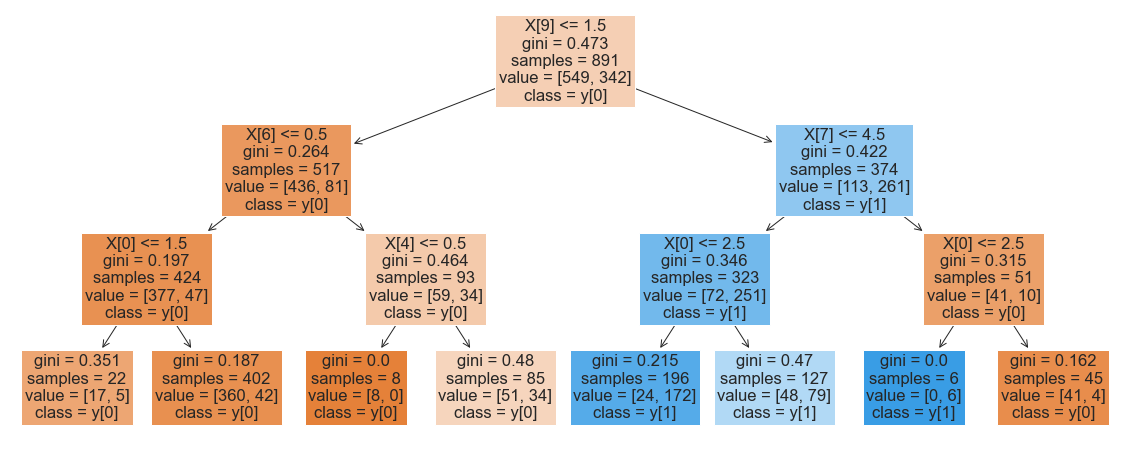

In [68]:
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)

plt.figure(figsize=(20, 8))
tr = tree.plot_tree(decision_tree, class_names=True, filled=True)